In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from datasets.nuscenes_ood import *
from tools.utils import *

import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
nusc, dataroot = get_nusc("mini", "../../data/nuscenes")
val_data = NuScenesDatasetOOD(nusc, False)

Anomaly


In [8]:
images, intrinsics, extrinsics, labels, oods, cam_oods = val_data[0]

1


(-0.5, 199.5, 199.5, -0.5)

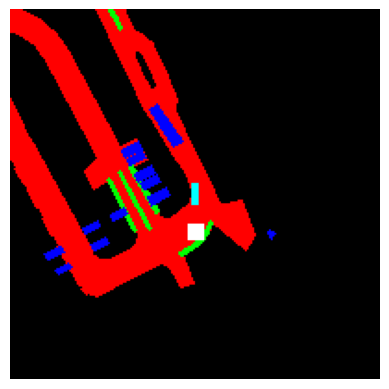

In [9]:
label_image = map_rgb(torch.tensor(labels), ego=True).astype(np.uint8)
label_image[oods == 1, :] = 255

plt.imshow(label_image)
plt.axis("off")

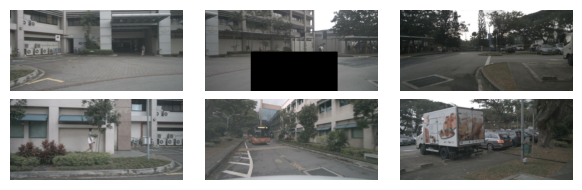

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(6, 2))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    images[i, :, cam_oods[i] == 1] = 0
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    
plt.tight_layout()

In [11]:
from diffusers import StableDiffusionInpaintPipeline
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp

# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-inpainting",
#     revision="fp16",
#     torch_dtype=torch.float16,
# )

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
pipe = pipe.to(0)

In [12]:

ci=1
image = images[ci].unsqueeze(0)
mask = torch.tensor(cam_oods[ci])[None].unsqueeze(0)

padding_top = 128 
padding_bottom = 128 

image_p = F.pad(image, (0, 0, padding_top, padding_bottom), 'constant', 0)
mask_p = F.pad(mask, (0, 0, padding_top, padding_bottom), 'constant', 0)
image_p = F.interpolate(image_p, size=(512, 512), mode='bilinear', align_corners=False) * 2 - 1
mask_p = F.interpolate(mask_p, size=(512, 512), mode='bilinear', align_corners=False)


In [13]:
print(image_p.shape, mask_p.shape)

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


In [14]:
image_r = F.interpolate(image, scale_factor=2, mode='bilinear', align_corners=False) 
mask_r = F.interpolate(mask, scale_factor=2, mode='bilinear', align_corners=False) 

# prompt = "One Brown bear, photorealistic, standing on the road, whole body visible, as large as possible"
prompt = "Single grey car, photorealistic, on the road, as large as possible"

result = pipe(
    prompt=prompt,
    image=image_r * 2 - 1, 
    mask_image=mask_r,
    width=960, height=448,
    output_type='np',
    strength=1.
)


  0%|          | 0/50 [00:00<?, ?it/s]

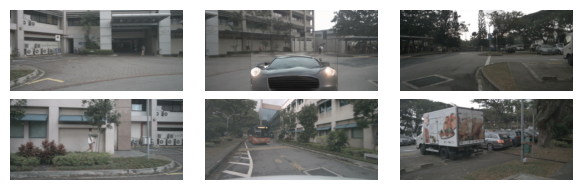

In [15]:
r = torch.tensor(result.images[0])[None].permute(0, 3, 1, 2)
r = F.interpolate(r, scale_factor=.5, mode='bilinear', align_corners=False) 
images[ci] = r

fig, axes = plt.subplots(2, 3, figsize=(6, 2))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(images[i].permute(1, 2, 0).numpy())

plt.tight_layout()

In [16]:
from models.evidential import Evidential

In [18]:
model = Evidential([0])
model.load(torch.load('../nuscenes/fiery_evidential/9.pt'))

Loaded pretrained weights for efficientnet-b4


In [19]:
out = model(images[None], intrinsics[None], extrinsics[None])

In [20]:
preds = model.activate(out)

(-0.5, 199.5, 199.5, -0.5)

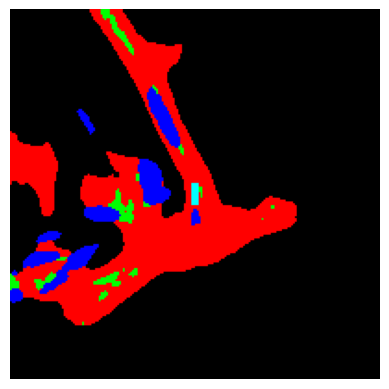

In [22]:
plt.imshow(map_rgb(preds[0], ego=True) / 255.)
plt.axis("off")

(-0.5, 199.5, 199.5, -0.5)

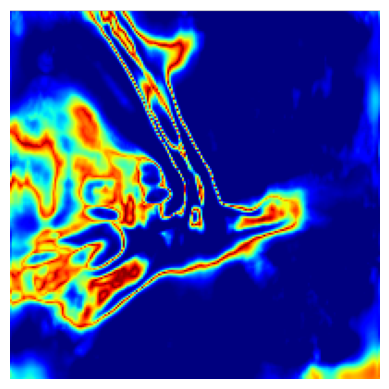

In [24]:
e = model.aleatoric(out)[0][0].detach().cpu()
e /= torch.max(e)
plt.imshow(plt.cm.jet(e))
plt.axis('off')